In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from source import data, plotting

### Data Generation

This notebook shows how to generate the data for the __2D__ and __6D__ model presented in the paper, as well as the Gaussian random fields of the fiducial parameter and its perturbations. 

The cosmological parameters as well as the random seeds are saved as compressed `numpy` arrays. We provide funtions to generate the random fields. 

Please note that the generation of the full dataset requires around 1.5 TB of space.

We start with an example for the two grids.

In [3]:
model_2d = np.load("../data/model_2d.npz")["data"]
model_6d = np.load("../data/model_6d.npz")["data"]

These arrays contain the sobol seed (index of the sobol sequence), the cosmological parameter (note that only two parameters vary for the __2D__ model) and the `numpy` random seeds used to generate the Gaussian random fields (GRF). The cosmological parameters are ordered as $\Omega_M$, $\Omega_b$, $h$, $n_s$, $\sigma_8$ and $w_0$

In [4]:
sample = model_2d[0]
print(f"Sobol index: {sample['i_sobol']}")
print(f"Cosmology:   {sample['cosmo']}")
print(f"numpy seeds: {sample['numpy_seeds']}")

Sobol index: 0
Cosmology:   [ 0.325   0.049   0.6711  0.9624  0.82   -1.    ]
numpy seeds: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


The survey settings, necessary to generate the data, are also saved as compressed `numpy` arrays. The survey settings include the redshift distributions of the tomographic bins, the survey mask and the padding necessary for the graph convolutional neural network (GCNN).

In [5]:
survey_settings = np.load("../data/survey_settings.npz")

We start by plotting the redshift distributions (compare to Figure 3 in the paper).

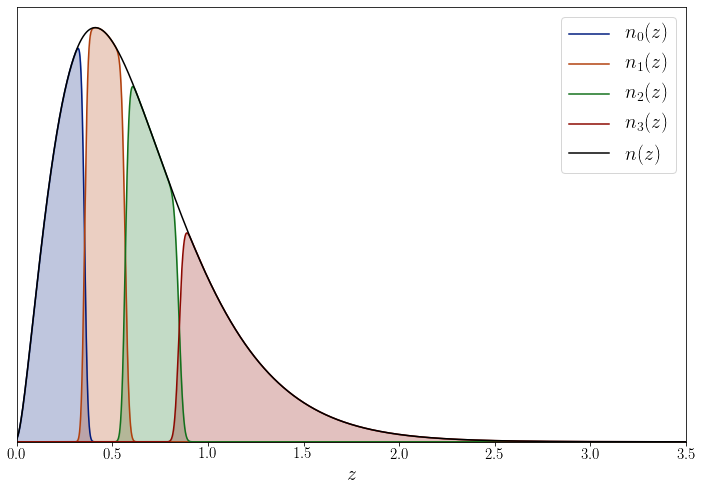

In [6]:
plotting.plot_n_of_z(survey_settings["n_of_z"])

Now we plot the patch and the padding.

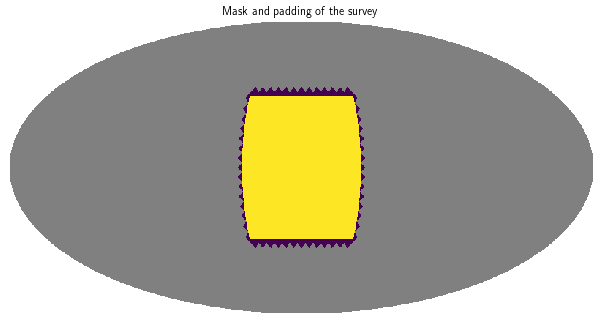

In [7]:
plotting.plot_patch(survey_settings["boolean_mask"], survey_settings["boolean_mask_pad"])

We proceed with the generation of the theoretical power spectra and plot them (including the cross spectra).

Calculating spectra...
(4, 4)


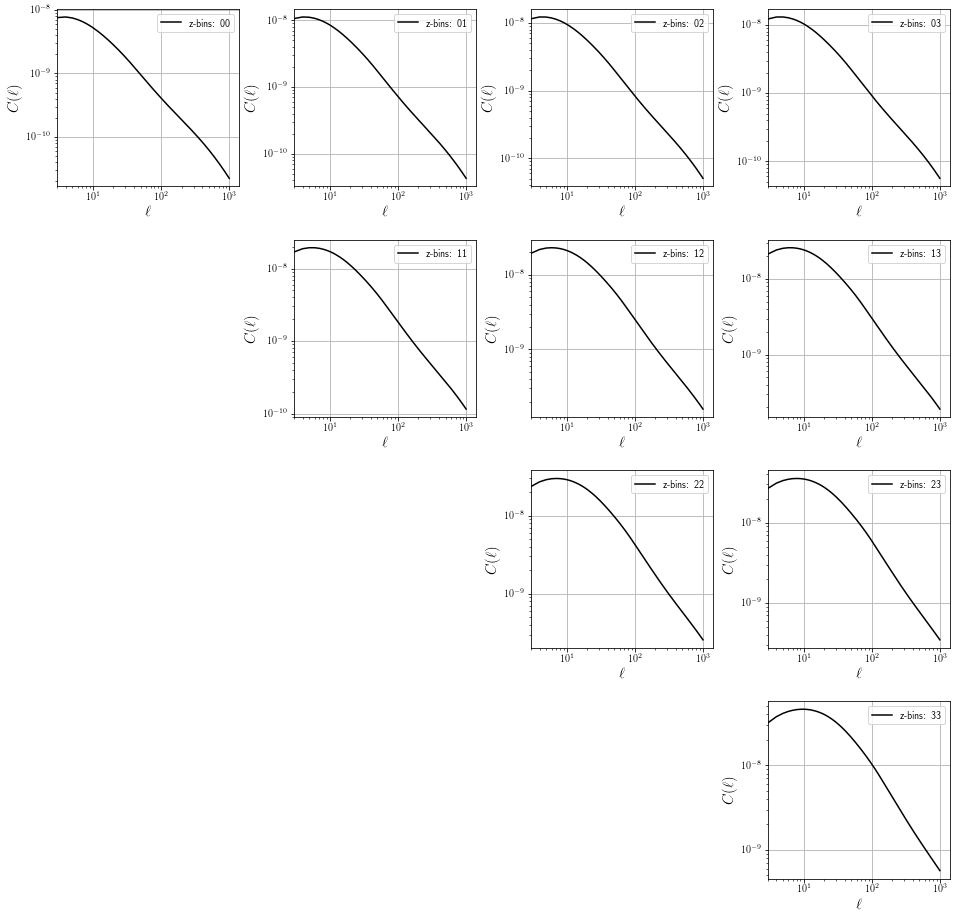

In [8]:
sample_sectra = data.gen_ccl_spectra(sample["cosmo"], survey_settings["n_of_z"])
plotting.plot_spectra(sample_sectra)

We proceed with the generation of the actual patches used to feed into the GCNN and plot them (compare to Figure 2 in the paper).

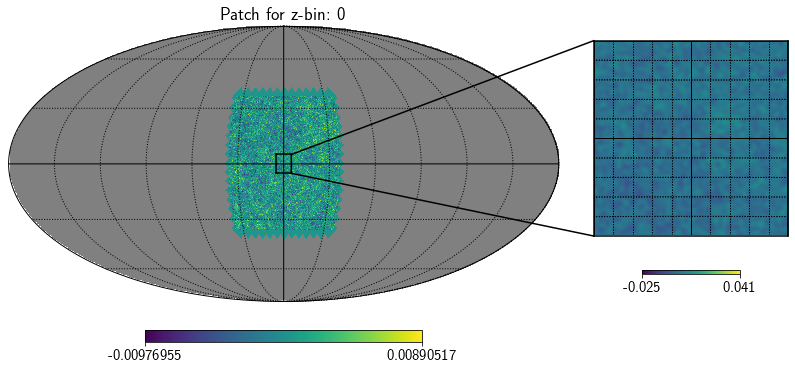

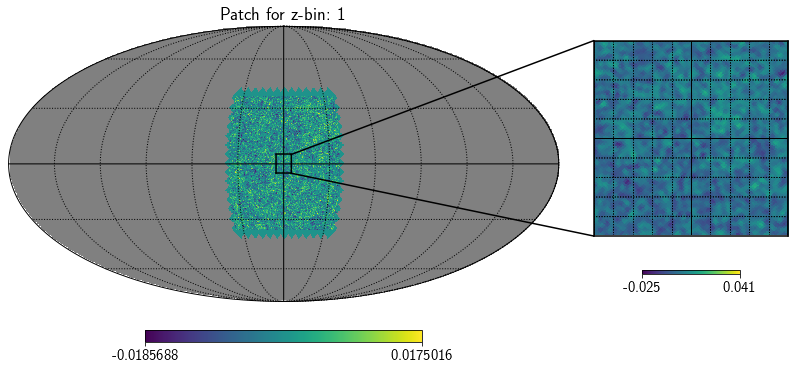

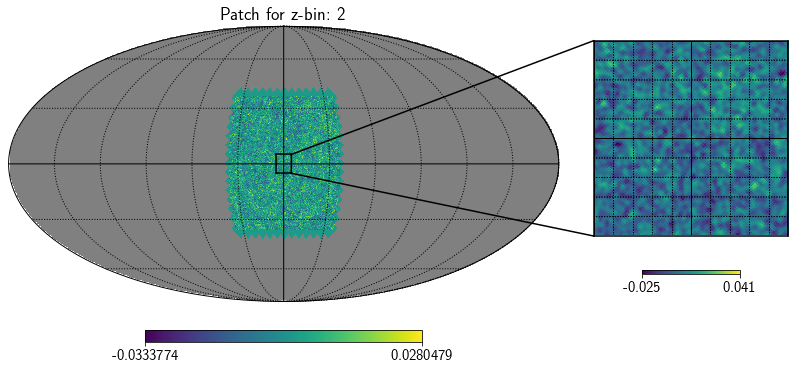

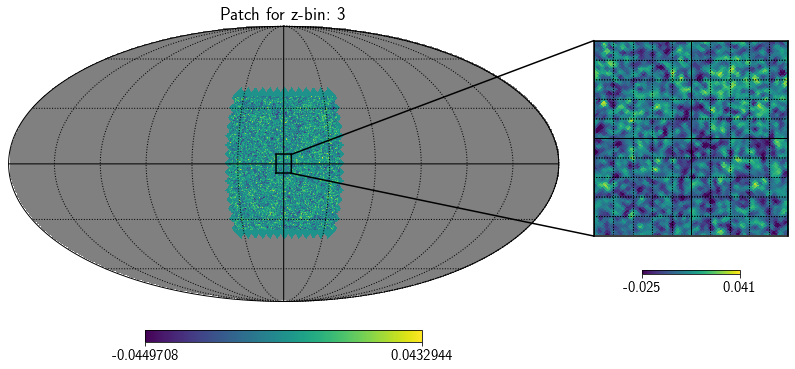

In [9]:
maps = data.create_GRF_samples(spectra=[sample_sectra], 
                               data_mask=survey_settings["boolean_mask"], 
                               data_mask_pad=survey_settings["boolean_mask_pad"], 
                               seed=sample["numpy_seeds"][0])[0]
# this routine takes channels first -> transpose
plotting.plot_patches_nice(maps.T, survey_settings["boolean_mask_pad"])

We proceed by showing how one can generate maps that are used for the training of the GCNN. The fiducial spectra and their perturbations are already saved as compressed array. The fiducial data contains the pre-calculated spectra and their perturbations, the parameters of the fiducial cosmology, the perturbations of the cosmological parameters and `numpy` random seeds used to generate the GRF. This means that we have a total of 13 spectra, ordered in the following way:
- The fiducial spectrum (unperturbed)
- The next two spectra where $\Delta\Omega_M$ was first subtraced from the fiducial parameters and then added
- This pattern continues in the same ordering of the parameters as listed above.

In [10]:
fiducial_data = np.load("../data/fiducial_data.npz")
print(f"Cosmology:     {fiducial_data['cosmo']}")
print(f"Perturbations: {fiducial_data['deltas']}")

Cosmology:     [ 0.3175  0.049   0.6711  0.9624  0.834  -1.    ]
Perturbations: [0.01  0.002 0.02  0.02  0.015 0.05 ]


We can use the same function as before to generate data with the fiducial spectra and their perturbations. Note that for the __2D__ model one does not need all the perturbations as four parameters are constant. This will take some time, as a total of $13 \times 4$ maps will be produced (13 perturbation, 4 redshifts bins).

In [11]:
fidu_maps = data.create_GRF_samples(spectra=fiducial_data["spectra"], 
                                    data_mask=survey_settings["boolean_mask"], 
                                    data_mask_pad=survey_settings["boolean_mask_pad"], 
                                    seed=fiducial_data["numpy_seeds"][0])

The ordering of the patches is the same as for the input spectra. Now we can see, how for example $w_0$ influences the GRF, by plotting the difference of the GRF generated with the fiducial parameters and the GRF generated with a perturbed $w_0$ value.

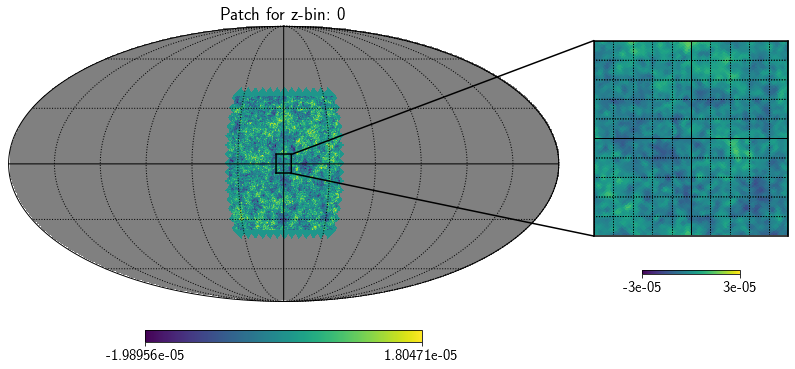

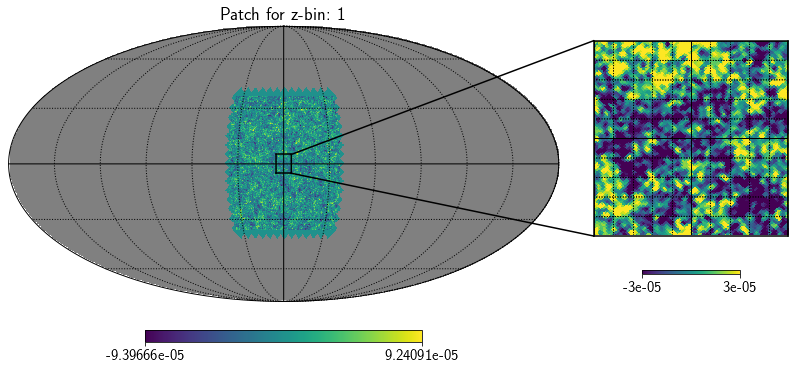

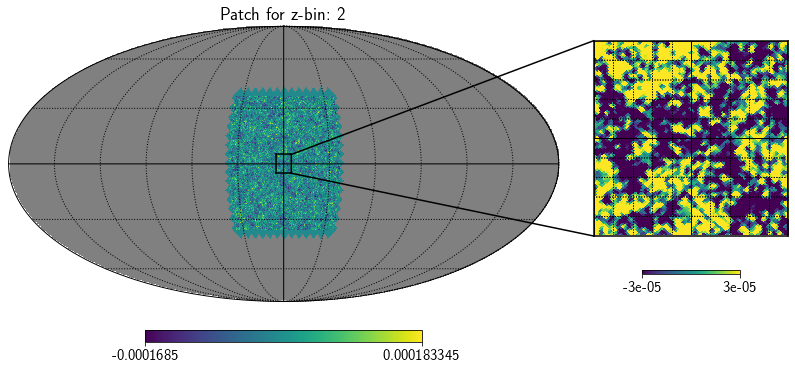

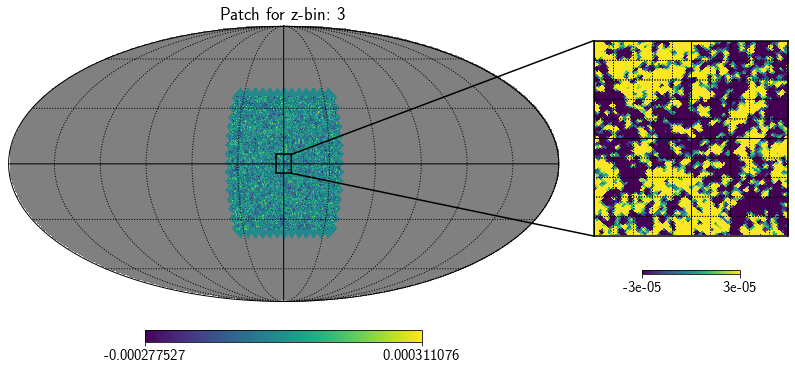

In [12]:
plotting.plot_patches_nice((fidu_maps[0] - fidu_maps[-1]).T, 
                            survey_settings["boolean_mask_pad"], 
                            clim=[-3e-5, 3e-5])

Using the functions of this notebook one can generate the entire dataset presented in the paper. The notebook `GCNN.ipynb` gives an overview on how to build and train a GCNN using the generated data.